<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/ANN_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [262]:
!pip install -U scikit-learn

In [263]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [264]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File ‘sp500sub.csv’ already there; not retrieving.



In [265]:
df0 = pd.read_csv("sp500sub.csv",index_col = 'Date',parse_dates = True)

In [266]:
df = df0[df0['Name'] == 'SBUX'][['Close']].copy()

In [267]:
df['LogClose'] = np.log(df['Close'])

In [268]:
df['DiffLogClose'] = df['LogClose'].diff()

In [269]:
NTest = 21
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [270]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['DiffLogClose']])
test_scaled = scaler.transform(test[['DiffLogClose']])

In [271]:
#Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

In [272]:
df.loc[train_idx,'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx,'ScaledLogReturn'] = test_scaled.flatten()

In [273]:
#Make supervised dataset
series = df['ScaledLogReturn'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
print("X shape: ",X.shape,' Y Shape: ',Y.shape)

X shape:  (2252, 10)  Y Shape:  (2252,)


In [274]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [275]:
#Basic ANN
i = Input(shape=(T,))
x = Dense(32,activation = 'relu')(i)
x = Dense(1)(x)
model = Model(i,x)

In [276]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [277]:
r = model.fit(
    XTrain,
    YTrain,
    epochs = 200,
    validation_data = (XTest,YTest)
)

Epoch 1/200
70/70 [==============================] - 1s 3ms/step - loss: 1.2158 - val_loss: 1.0195
Epoch 2/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0848 - val_loss: 0.9892
Epoch 3/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0407 - val_loss: 0.9815
Epoch 4/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0181 - val_loss: 0.9711
Epoch 5/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0044 - val_loss: 0.9639
Epoch 6/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9921 - val_loss: 0.9474
Epoch 7/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9823 - val_loss: 0.9498
Epoch 8/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9745 - val_loss: 0.9322
Epoch 9/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9683 - val_loss: 0.9506
Epoch 10/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9632 - val_loss: 0.9448
Epoch 11/

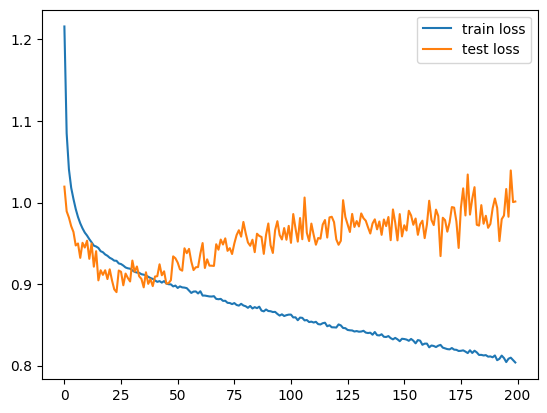

In [278]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

In [279]:
#The first T+1 values are not predictable
train_idx[:T+1] = False

In [280]:
PTrain = model.predict(XTrain)
PTest = model.predict(XTest)

1/1 [==============================] - 0s 16ms/step


In [281]:
#Invert the scalling
PTrain = scaler.inverse_transform(PTrain).flatten()
PTest = scaler.inverse_transform(PTest).flatten()

In [282]:
#Store diff predictions
df.loc[train_idx,'Diff ANN Train Prediction'] = PTrain
df.loc[test_idx,'Diff ANN Test Prediction'] = PTest

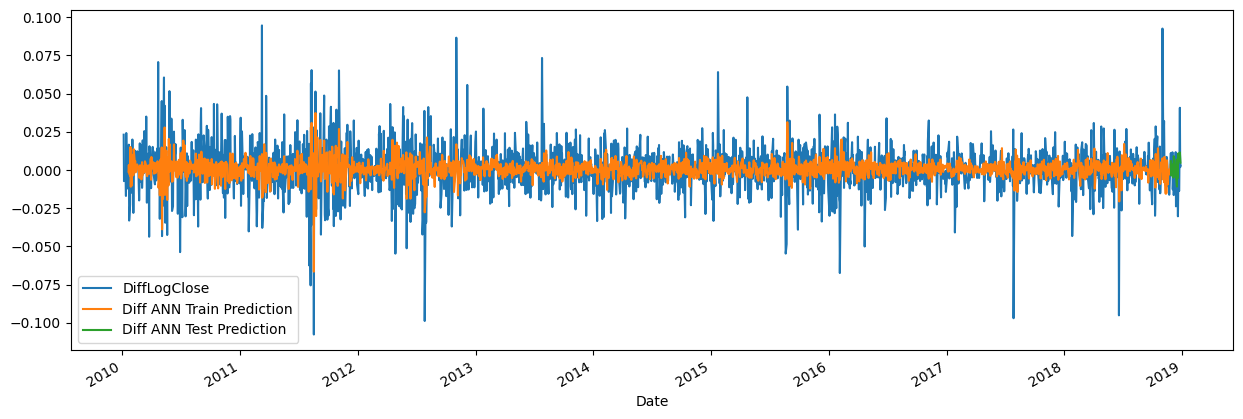

In [283]:
cols = [
    'DiffLogClose',
    'Diff ANN Train Prediction',
    'Diff ANN Test Prediction'
]
df[cols].plot(figsize = (15,5));

In [284]:
#Needed to compute un-differenced predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

In [285]:
#Last-known train value
last_train = train.iloc[-1]['LogClose']

In [286]:
#1-step forecast
df.loc[train_idx,'1step_train'] = prev[train_idx] + PTrain
df.loc[test_idx,'1step_test'] = prev[test_idx] + PTest

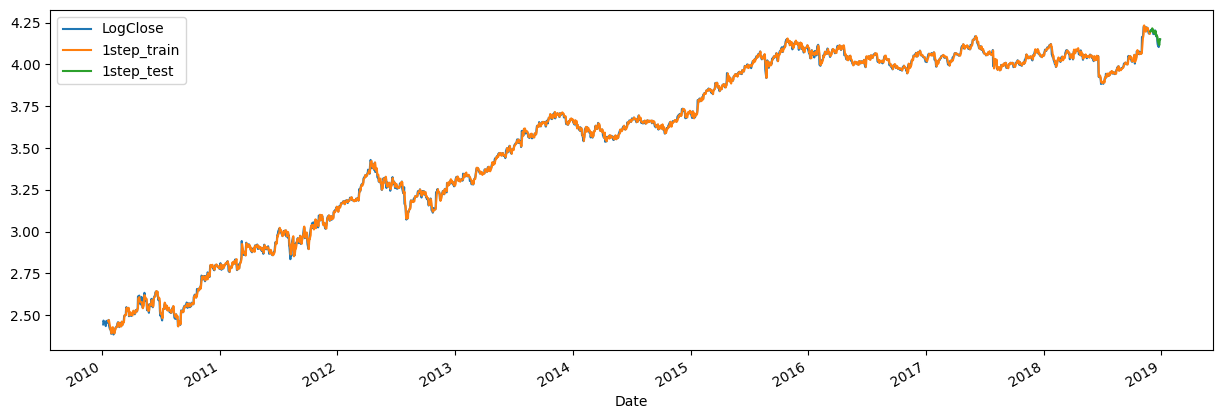

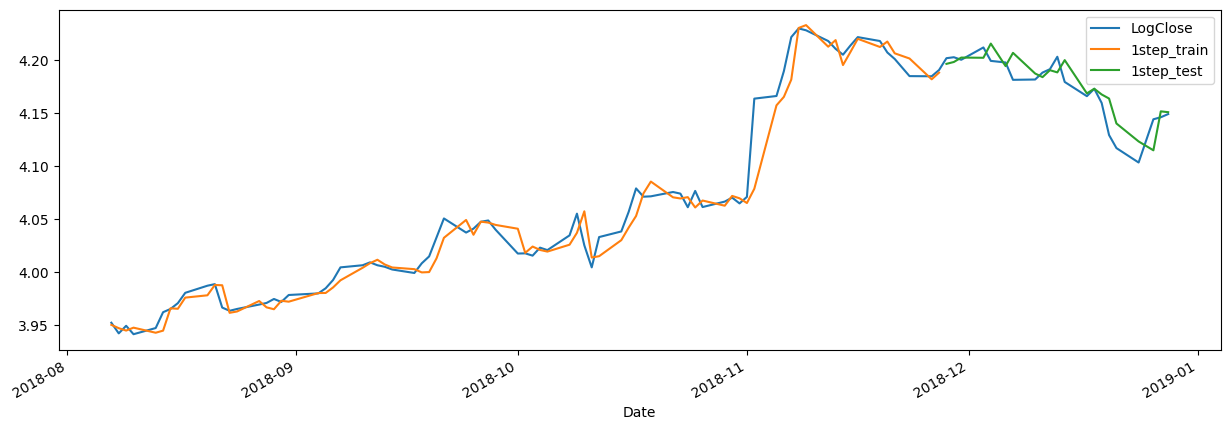

In [287]:
#Plot 1 step forecast
cols = [
    'LogClose',
    '1step_train',
    '1step_test'
]
df[cols].plot(figsize = (15,5))
df.iloc[-100:][cols].plot(figsize = (15,5));

In [288]:
#multi-step forecast
multistep_predictions = []

#first test input
last_x = XTest[0]

while len(multistep_predictions) < NTest:
  p = model.predict(last_x.reshape(1,-1))[0]

  #Update the prediction list
  multistep_predictions.append(p)

  #Make the new input
  last_x = np.roll(last_x,-1)
  last_x[-1] = p

1/1 [==============================] - 0s 15ms/step


In [289]:
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(
    multistep_predictions.reshape(-1,1)
)
multistep_predictions = multistep_predictions.flatten()
multistep_predictions

array([ 0.0057897 , -0.00362498,  0.00043618,  0.00184921,  0.00449022,
       -0.00086311,  0.00174191,  0.00298785, -0.00011507,  0.0007873 ,
        0.00128288, -0.00238944, -0.0016021 ,  0.00166716, -0.00373749,
       -0.00226816,  0.00085914, -0.00172798, -0.00257161,  0.00014599,
       -0.001143  ], dtype=float32)

In [290]:
#Save multi-step forecast to dataframe
df.loc[test_idx,'multistep'] = last_train + np.cumsum(multistep_predictions)

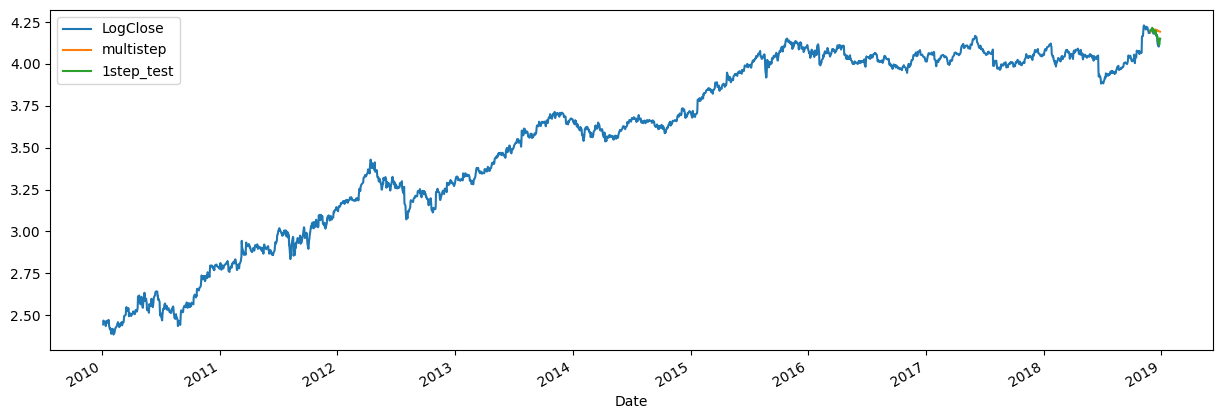

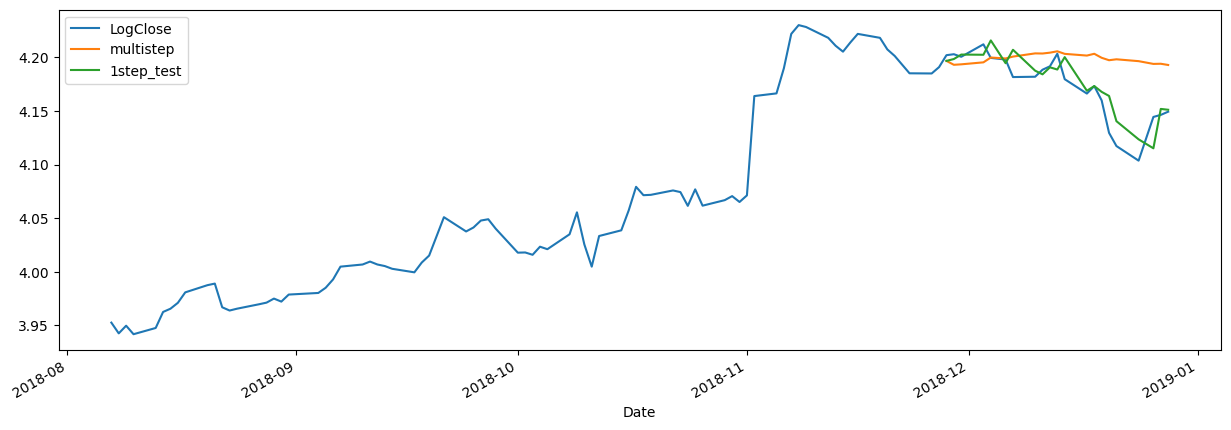

In [291]:
cols = [
    'LogClose',
    'multistep',
    '1step_test'
]

df[cols].plot(figsize = (15,5))
df.iloc[-100:][cols].plot(figsize = (15,5));

In [292]:
#Make multi-output supervised dataset
Tx = T
Ty = NTest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t : t + Tx]
  X.append(x)
  y = series[t + Tx:t + Tx + Ty]
  Y.append(y)

In [293]:
X = np.array(X).reshape(-1,Tx)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)

In [294]:
XTrain_m,YTrain_m = X[:-1],Y[:-1]
XTest_m,YTest_m = X[-1:],Y[-1:]

In [295]:
#Basic ANN
i = Input(shape = (Tx,))
x = Dense(32,activation = 'relu')(i)
x = Dense(1)(x)
model = Model(i,x)

In [296]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [297]:
r = model.fit(
    XTrain_m,
    YTrain_m,
    epochs = 100,
    validation_data = (XTest_m,YTest_m)
)

Epoch 1/100
70/70 [==============================] - 1s 3ms/step - loss: 1.2032 - val_loss: 0.9937
Epoch 2/100
70/70 [==============================] - 0s 1ms/step - loss: 1.0698 - val_loss: 1.0211
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0469 - val_loss: 1.0298
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0326 - val_loss: 1.0315
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0230 - val_loss: 1.0415
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0162 - val_loss: 1.0439
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0117 - val_loss: 1.0380
Epoch 8/100
70/70 [==============================] - 0s 1ms/step - loss: 1.0086 - val_loss: 1.0379
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0060 - val_loss: 1.0414
Epoch 10/100
70/70 [==============================] - 0s 1ms/step - loss: 1.0043 - val_loss: 1.0413
Epoch 11/

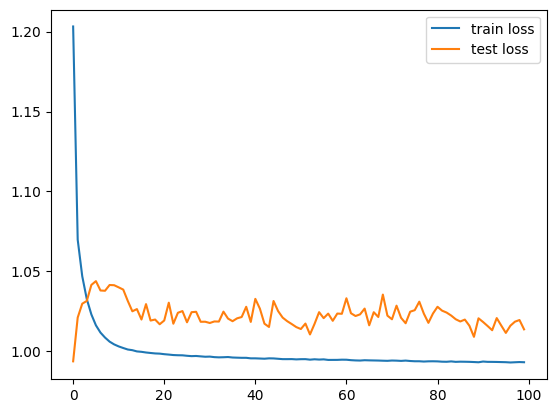

In [298]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend()

In [299]:
PTrain = model.predict(XTrain)
PTest = model.predict(XTest)

1/1 [==============================] - 0s 17ms/step


In [300]:
PTrain.shape,PTest.shape

((2231, 1), (21, 1))

In [301]:
PTrain = PTrain[:,0]
PTest = PTest[0]

In [302]:
#Unscale the data
PTest = scaler.inverse_transform(PTest.reshape(-1,1)).flatten()

In [303]:
df.loc[test_idx,'multioutput'] = last_train + np.cumsum(PTest)

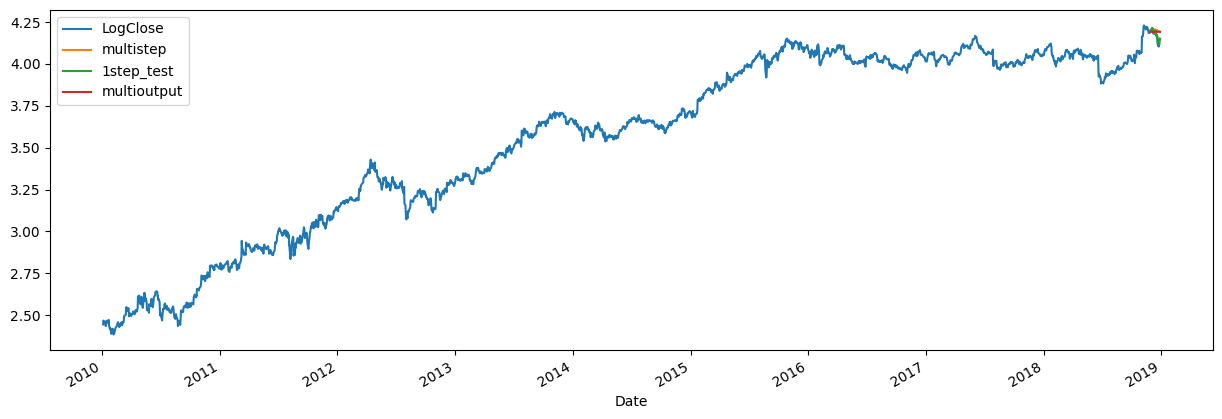

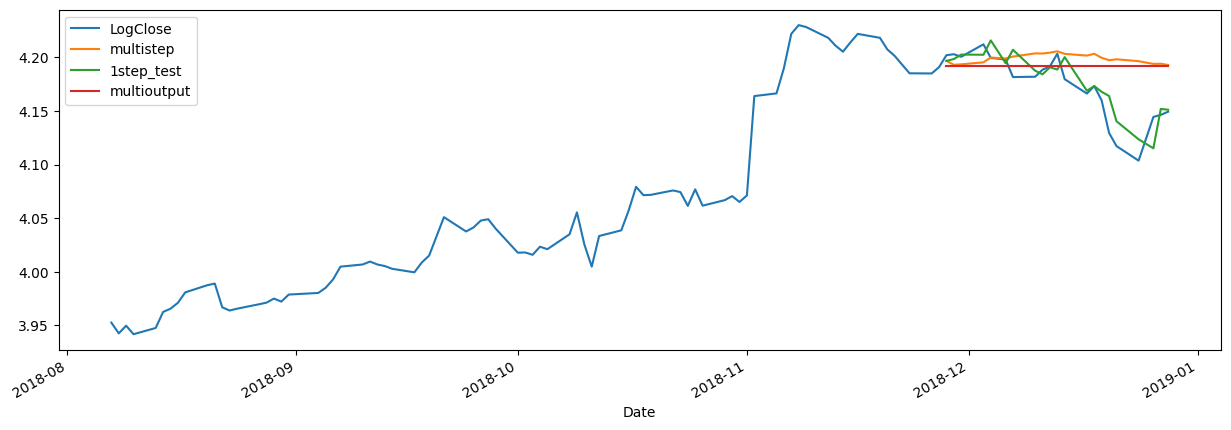

In [304]:
cols = [
    'LogClose',
    'multistep',
    '1step_test',
    'multioutput'
]
df[cols].plot(figsize = (15,5))
df.iloc[-100:][cols].plot(figsize = (15,5));

In [305]:
#MAPE
test_log_pass = df.loc[test_idx,'LogClose']
mape1 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'multistep']
)
print('multi-step   mape: ',mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'multioutput']
)
print('multi-output mape: ',mape2)

multi-step   mape:  0.007148047408364671
multi-output mape:  0.006309502012202152


# **1-Step Binary Classification**

In [306]:
YTrain_b = (YTrain > 0) * 1
YTest_b = (YTest > 0) * 1

In [307]:
#Basic ANN
i = Input(shape=(T,))
x = Dense(32,activation = 'relu')(i)
x = Dense(1)(i)
model = Model(i,x)

In [308]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy'],
    run_eagerly=True
)

In [309]:
r = model.fit(
    XTrain,
    YTrain_b,
    epochs = 100,
    validation_data = (XTest,YTest_b)
)

Epoch 1/100
70/70 [==============================] - 1s 21ms/step - loss: 0.8097 - accuracy: 0.5096 - val_loss: 0.9391 - val_accuracy: 0.3333
Epoch 2/100
70/70 [==============================] - 1s 14ms/step - loss: 0.7899 - accuracy: 0.5096 - val_loss: 0.9123 - val_accuracy: 0.3333
Epoch 3/100
70/70 [==============================] - 1s 14ms/step - loss: 0.7731 - accuracy: 0.5052 - val_loss: 0.8866 - val_accuracy: 0.3333
Epoch 4/100
70/70 [==============================] - 1s 14ms/step - loss: 0.7583 - accuracy: 0.5038 - val_loss: 0.8651 - val_accuracy: 0.3333
Epoch 5/100
70/70 [==============================] - 1s 13ms/step - loss: 0.7454 - accuracy: 0.5092 - val_loss: 0.8443 - val_accuracy: 0.3333
Epoch 6/100
70/70 [==============================] - 1s 14ms/step - loss: 0.7345 - accuracy: 0.5065 - val_loss: 0.8253 - val_accuracy: 0.3333
Epoch 7/100
70/70 [==============================] - 1s 14ms/step - loss: 0.7254 - accuracy: 0.5087 - val_loss: 0.8085 - val_accuracy: 0.3333
Epoch 

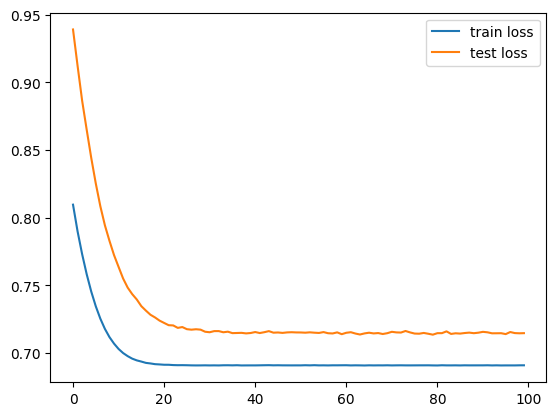

In [310]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

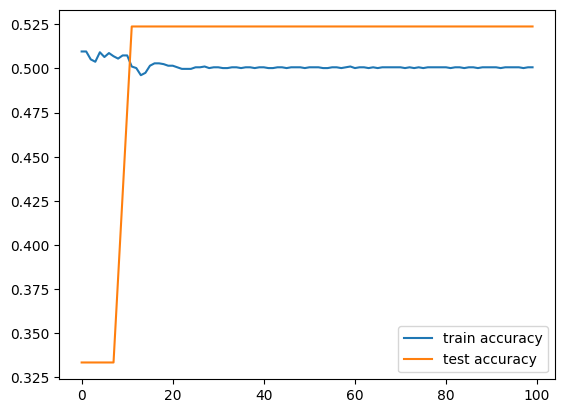

In [311]:
plt.plot(r.history['accuracy'],label = 'train accuracy')
plt.plot(r.history['val_accuracy'],label = 'test accuracy')
plt.legend();